# Searching for structure in ImmGen

In [1]:
from sklearn import datasets, decomposition, manifold, preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import scale

import umap

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

from colorsys import hsv_to_rgb

In [2]:
def read_ImmGen_csv(fname):
    df = pd.read_csv(fname, header=None, low_memory=False)
    df_feature_names = np.concatenate((['Cell_type'], df.iloc[:, 1].values[1:]))
    df = df.T.drop([0, 1], axis=0)
    df.columns = df_feature_names
    df = df.set_index('Cell_type')
    return df

In [3]:
ImmGen_raw = read_ImmGen_csv('ImmGen_raw.csv')
centered_ImmGen_raw = scale(ImmGen_raw, with_mean='True', with_std='False')
centered_ImmGen_raw_df = pd.DataFrame(centered_ImmGen_raw, columns=ImmGen_raw.columns, index=ImmGen_raw.index)
hematopoetic_class = [immgenName.split('.')[0] for immgenName in ImmGen_raw.index]
centered_ImmGen_raw_df.insert(0, 'Hematopoetic_class', hematopoetic_class)
centered_ImmGen_raw_df[~centered_ImmGen_raw_df.Hematopoetic_class.str.contains("#")]
cell_class = {}
for i in range(len(hematopoetic_class)):
    cell_class[hematopoetic_class[i]] = i
i=0
for key, val in cell_class.items():
    cell_class[key] = i
    i += 1
class_labels = [cell_class[hematopoetic_class[i]] for i in range(len(hematopoetic_class))]
centered_ImmGen_raw_df.insert(1, 'Hematopoetic_class_int', class_labels)

C:\Users\Duncan\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype object were all converted to float64 by the scale function.
  


# Comparing naive cells to IFN$\gamma$ stimulation

In [4]:
gene_response_df = read_ImmGen_csv("ImmGen_IFNg_response_GSE112876_Normalized_Data.csv")
gene_naive_df = read_ImmGen_csv('ImmGen_raw.csv')
labels = ['IFNg Stimulated', 'Naive']
for df in [gene_response_df, gene_naive_df]:
    df.index= [i.split(".")[0] for i in df.index.values]
    df.insert(0, 'Dataset', [labels[0] for _ in range(len(df.index.values))])
    labels = labels[1:]

core_cell_types = []
for x in gene_response_df.index.values:
    if x not in core_cell_types:
        core_cell_types.append(x)
common_core_cell_types = [i for i in core_cell_types if i in gene_naive_df.index.values]

combined_cell_types = pd.concat((gene_naive_df.loc[common_core_cell_types], gene_response_df.loc[common_core_cell_types]))

cell_class = {}
for idx, i in enumerate(common_core_cell_types):
    cell_class[i] = idx
class_labels = [cell_class[combined_cell_types.index.values[i]] for i in range(len(combined_cell_types.index.values))]
combined_cell_types.insert(1, 'Hematopoetic_class_int', class_labels)

dataset_labels = []
for l in combined_cell_types.Dataset.values:
    if l == 'Naive':
        dataset_labels.append(0)
    else:
        dataset_labels.append(1)    
combined_cell_types.insert(1, 'Dataset_int', dataset_labels)

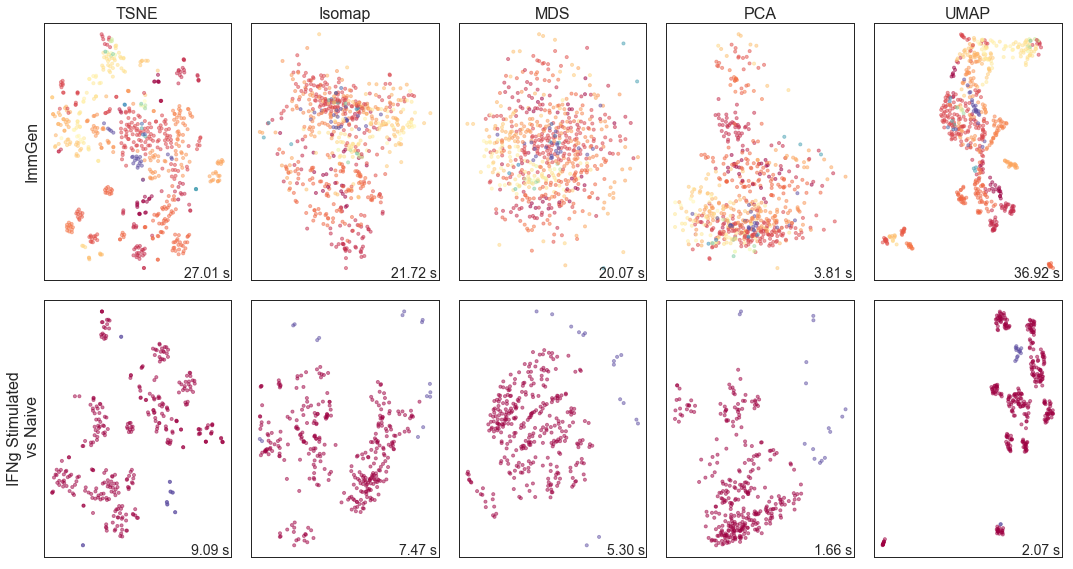

In [5]:
reducers = [
    (manifold.TSNE, {"perplexity": 50}),
    # (manifold.LocallyLinearEmbedding, {'n_neighbors':10, 'method':'hessian'}),
    (manifold.Isomap, {"n_neighbors": 30}),
    (manifold.MDS, {}),
    (decomposition.PCA, {}),
    (umap.UMAP, {"n_neighbors": 30, "min_dist": 0.3}),
]



test_data = [
    (centered_ImmGen_raw_df.drop(['Hematopoetic_class', 'Hematopoetic_class_int'], axis=1).values, 
     centered_ImmGen_raw_df.Hematopoetic_class_int.values),
    
    (combined_cell_types.drop(['Dataset', 'Dataset_int', 'Hematopoetic_class_int'], axis=1).values,
     combined_cell_types.Dataset_int.values)
]
dataset_names = ["ImmGen", "IFNg Stimulated\n vs Naive"]

sns.set(context="paper", style="white")
n_rows = len(test_data)
n_cols = len(reducers)
ax_index = 1
ax_list = []

plt.figure(figsize=(15, 8))

for data, labels in test_data:
    for reducer, args in reducers:
        start_time = time.time()
        embedding = reducer(n_components=2, **args).fit_transform(data)
        elapsed_time = time.time() - start_time
        ax = plt.subplot(n_rows, n_cols, ax_index)
        if isinstance(labels[0], tuple):
            ax.scatter(*embedding.T, s=10, c=labels, alpha=0.5)
        else:
            ax.scatter(
                *embedding.T, s=10, c=labels, cmap="Spectral", alpha=0.5
            )
        ax.text(
            0.99,
            0.01,
            "{:.2f} s".format(elapsed_time),
            transform=ax.transAxes,
            size=14,
            horizontalalignment="right",
        )
        ax_list.append(ax)
        ax_index += 1
plt.setp(ax_list, xticks=[], yticks=[])

for i in np.arange(n_rows) * n_cols:
    ax_list[i].set_ylabel(dataset_names[i // n_cols], size=16)
for i in range(n_cols):
    ax_list[i].set_xlabel(repr(reducers[i][0]()).split("(")[0], size=16)
    ax_list[i].xaxis.set_label_position("top")

plt.tight_layout()
plt.show()

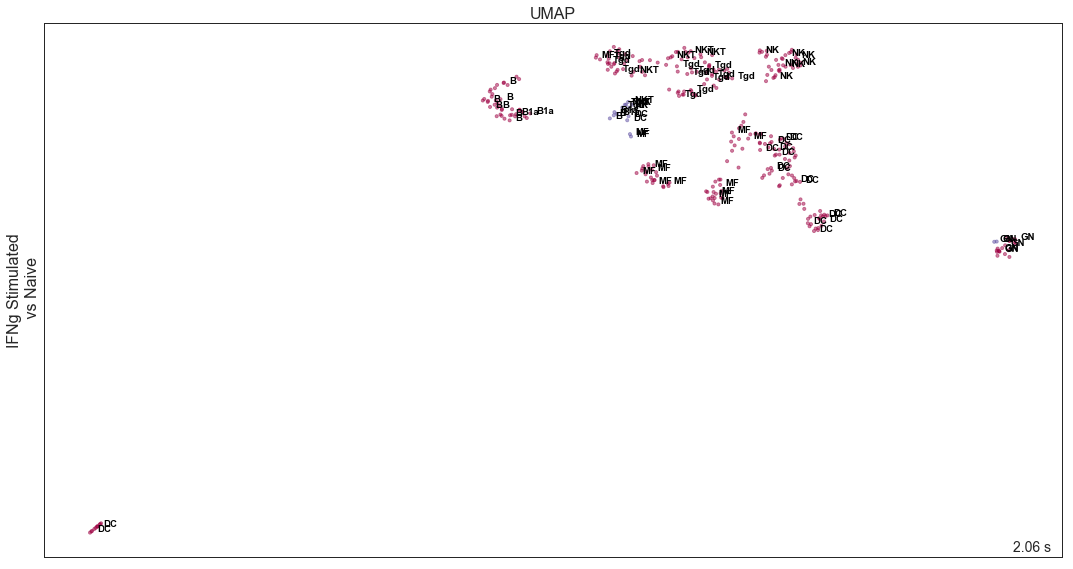

In [6]:
reducers = [
    (umap.UMAP, {"n_neighbors": 30, "min_dist": 0.3}),
]

test_data = [
    (combined_cell_types.drop(['Dataset', 'Dataset_int', 'Hematopoetic_class_int'], axis=1).values,
     combined_cell_types.Dataset_int.values)
]
dataset_names = ["IFNg Stimulated\n vs Naive"]

sns.set(context="paper", style="white")
n_rows = len(test_data)
n_cols = len(reducers)
ax_index = 1
ax_list = []

fig = plt.figure(figsize=(15,8))

for data, labels in test_data:
    for reducer, args in reducers:
        start_time = time.time()
        embedding = reducer(n_components=2, **args).fit_transform(data)
        elapsed_time = time.time() - start_time
        ax = plt.subplot(n_rows, n_cols, ax_index)
        if isinstance(labels[0], tuple):
            ax.scatter(*embedding.T, s=10, c=labels, alpha=0.5)
        else:
            ax.scatter(
                *embedding.T, s=10, c=labels, cmap="Spectral", alpha=0.5
            )
        ax.text(
            0.99,
            0.01,
            "{:.2f} s".format(elapsed_time),
            transform=ax.transAxes,
            size=14,
            horizontalalignment="right",
        )
        # add annotations one by one with a loop
        for line in list(range(0,combined_cell_types.shape[0]-16, 5)) + list(range(combined_cell_types.shape[0]-16, combined_cell_types.shape[0])):
            ax.text(embedding.T[0][line]+0.2, embedding.T[1][line], combined_cell_types.index.values[line], 
                    horizontalalignment='left', size='medium', color='black', weight='semibold')
        
        ax_list.append(ax)
        ax_index += 1
plt.setp(ax_list, xticks=[], yticks=[])

for i in np.arange(n_rows) * n_cols:
    ax_list[i].set_ylabel(dataset_names[i // n_cols], size=16)
for i in range(n_cols):
    ax_list[i].set_xlabel(repr(reducers[i][0]()).split("(")[0], size=16)
    ax_list[i].xaxis.set_label_position("top")

plt.tight_layout()
plt.savefig("IFNg_Umap.pdf")
plt.show()

